In [1]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

import copy

from models.cnn_model import CNNModel

from utils import * 

torch.manual_seed(1)

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


In [3]:
df = df1

df

,consumption,temperature
2017-05-01 00:00:00+00:00,3325.431995,2.200000
2017-05-01 01:00:00+00:00,3344.690998,3.200000
2017-05-01 02:00:00+00:00,3398.359002,4.000000
2017-05-01 03:00:00+00:00,3430.220001,3.600000
2017-05-01 04:00:00+00:00,3606.750000,3.400000
...,...,...
2023-01-21 19:00:00+00:00,5947.502808,-10.233333
2023-01-21 20:00:00+00:00,5868.196111,-11.266667
2023-01-21 21:00:00+00:00,5742.156776,-12.016667
2023-01-21 22:00:00+00:00,5653.673398,-12.083333


In [4]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1, shuffle=False)

In [5]:
# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize train and test set
df_train = (df_train - train_mean) / train_std
df_validation = (df_validation - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [6]:
df_train

,consumption,temperature
2017-05-01 00:00:00+00:00,-0.520736,-0.713648
2017-05-01 01:00:00+00:00,-0.506271,-0.593681
2017-05-01 02:00:00+00:00,-0.465960,-0.497708
2017-05-01 03:00:00+00:00,-0.442029,-0.545695
2017-05-01 04:00:00+00:00,-0.309436,-0.569688
...,...,...
2021-12-20 07:00:00+00:00,1.151071,-0.553693
2021-12-20 08:00:00+00:00,1.168536,-0.611676
2021-12-20 09:00:00+00:00,1.153706,-0.531699
2021-12-20 10:00:00+00:00,1.116430,-0.527700


In [7]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
    

In [8]:
tw = 100
pw = 1

train_dataset = SequenceDataset(generate_cnn_sequences(df_train, tw, pw))
val_dataset = SequenceDataset(generate_cnn_sequences(df_validation, tw, pw))
test_dataset = SequenceDataset(generate_cnn_sequences(df_test, tw, pw))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
x, y = next(iter(train_loader))

print(x[0])
print(y[0])

tensor([[-1.1490,  0.9519],
        [-1.2635,  0.8819],
        [-1.3267,  0.8179],
        [-1.3609,  0.7939],
        [-1.3798,  0.8059],
        [-1.2991,  0.8899],
        [-1.0480,  0.9139],
        [-0.7248,  0.8059],
        [-0.5794,  0.9619],
        [-0.5847,  1.1098],
        [-0.5703,  1.0998],
        [-0.5546,  0.9939],
        [-0.4992,  0.8299],
        [-0.4738,  0.7759],
        [-0.4607,  0.7559],
        [-0.4531,  0.7519],
        [-0.4191,  0.7479],
        [-0.4747,  0.9599],
        [-0.5644,  1.0499],
        [-0.6152,  1.1198],
        [-0.6700,  0.9739],
        [-0.7057,  0.8379],
        [-0.7789,  0.6080],
        [-0.8733,  0.5140],
        [-1.0352,  0.3181],
        [-1.1475,  0.1241],
        [-1.1972,  0.0761],
        [-1.2285, -0.0738],
        [-1.2433, -0.1158],
        [-1.1736, -0.0238],
        [-0.9413,  0.4100],
        [-0.6374,  0.6980],
        [-0.5247,  0.9159],
        [-0.5306,  1.0259],
        [-0.5483,  1.0719],
        [-0.5706,  1

In [11]:
def validation(val_loader, criterion, model):
    model.eval()
    val_losses = []
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        y = y.squeeze()
        preds = model(x).squeeze()
        val_loss = criterion(preds, y)
        val_losses.append(val_loss)
    print(f"Validation Loss: {sum(val_losses) / len(val_losses)}")
    return sum(val_losses) / len(val_losses)

In [12]:

model = CNNModel(tw=100)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

losses = []
losses_show = []
val_losses = []
for epoch in range(20):
    model.train()

    epoch_losses = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        preds = model(x)

        loss = criterion(preds, y)

        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
        losses.append(loss.item())
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])
    
    print(f"Epch {epoch} loss: {sum(epoch_losses) / len(epoch_losses)}")
    val_loss = validation(val_loader, criterion, model)
    val_losses.append(val_loss.item())

# Save model parameters
torch.save(model.state_dict(), 'trained_models/cnn.pth')

Epch 0 loss: 0.054728076386764565
Validation Loss: 0.0160971712321043
Epch 1 loss: 0.01900318596510609
Validation Loss: 0.008857620880007744
Epch 2 loss: 0.013569351765691011
Validation Loss: 0.008819006383419037
Epch 3 loss: 0.011271780047671548
Validation Loss: 0.006629294250160456
Epch 4 loss: 0.009419173522850157
Validation Loss: 0.005839847959578037
Epch 5 loss: 0.008352023125431356
Validation Loss: 0.00628660898655653
Epch 6 loss: 0.007109836652164143
Validation Loss: 0.004853634629398584
Epch 7 loss: 0.006713503841038767
Validation Loss: 0.007324678357690573
Epch 8 loss: 0.006260994439279395
Validation Loss: 0.006346672307699919
Epch 9 loss: 0.005786003558341511
Validation Loss: 0.004286128096282482
Epch 10 loss: 0.005499014308543445
Validation Loss: 0.011065217666327953
Epch 11 loss: 0.004909611417757216
Validation Loss: 0.00469210185110569
Epch 12 loss: 0.004841981493539362
Validation Loss: 0.009909410029649734
Epch 13 loss: 0.0046363782734685855
Validation Loss: 0.00346689159

1267


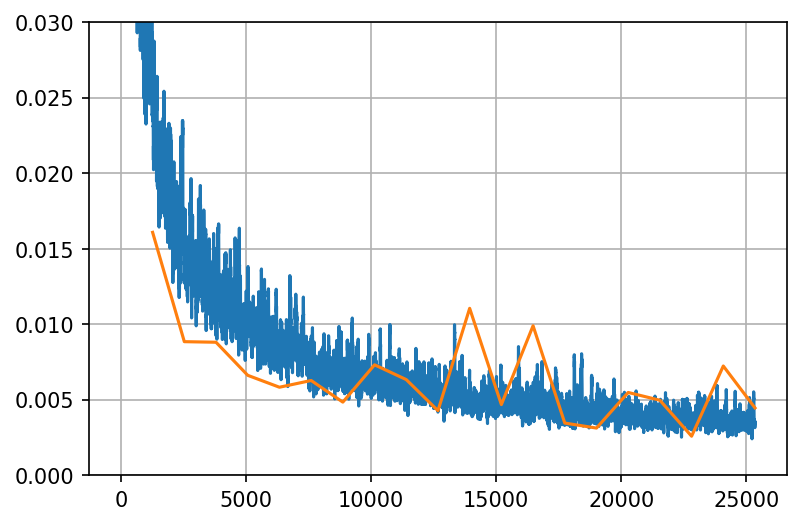

In [13]:
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.ylim(0, 0.03)

print(len(losses_show) // len(val_losses))

plt.plot(range(len(losses_show)), losses_show)
plt.plot(range(len(losses_show) // len(val_losses), len(losses_show)+1, len(losses_show) // len(val_losses)), val_losses)
plt.show()

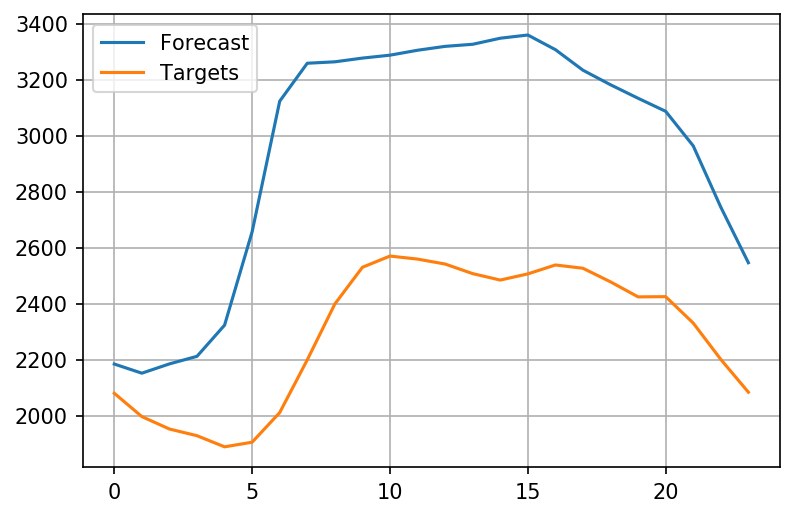

In [14]:
# Forecasting
start_point = 1200
tw = 100
fw = 24

history = df_test.copy(deep=True)[start_point: start_point+tw+fw].values
targets = copy.deepcopy(history)[tw:tw+fw][:, 0]

predictions = []

# 24 timesteps into the future
for i in range(fw):
    x = history[i:tw+i].reshape(-1, 2)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    p = model(x)

    predictions.append(p.item())
    history[-fw+i, 0] = p.item()


predictions = np.array(predictions) * train_std['consumption'] + train_mean['consumption']
targets = np.array(targets) * train_std['consumption'] + train_mean['consumption']

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()